# pyBATMAN

This notebook demonstrates the current state of our CPMG (small molecules) NMR pipeline. 

The boring signal processing part has been done, and we are ready to move to the more fun parts of: 
- Adding more metabolite specifications into the system. Currently only a few have been added by me. Need to sit down together with Naomi and go through them one by one.
- Getting good fits on the metabolites (tweaking parameters etc. either manually or automatically .. somehow)
- Making predictions on their concentrations.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# initialise plotly in offline mode
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

Import the packages that we need

In [2]:
import pylab as plt
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import nmrglue as ng

import batman
from batman import PyBatman, PyBatmanOptions, PyBatmanOutput, Database, Metabolite

In [3]:
import warnings
warnings.filterwarnings("ignore") # suppress annoying warnings

# 1. Set Database

Set up a database of a few multiplets. This can also be read from a CSV file or other formats .. We can even build a nice interface around this if time allows.

In [4]:
db = Database()

db.add(Metabolite('TSP', [(-0.05, 0.05)])                                  
       .add(ppm=0, couple_code=0, j_constant=0, rel_intensity=9))

db.add(Metabolite('Acetate', [(1.92, 1.95)])                               
       .add(ppm=1.934, couple_code=0, j_constant=0, rel_intensity=3))

# a lot of overlap on the 3.8 multiplet for alanine, not using it ..
# db.add(Metabolite('Alanine', [(1.45, 1.54), (3.75, 3.85)])               
#        .add(ppm=1.495, couple_code=1, j_constant=7.21, rel_intensity=3)  
#        .add(ppm=3.803, couple_code=3, j_constant=7.3, rel_intensity=1))

db.add(Metabolite('Alanine', [(1.45, 1.54)])                               
       .add(ppm=1.495, couple_code=1, j_constant=7.21, rel_intensity=3))   

db.add(Metabolite('Citrate', [(2.48, 2.74)])                                 
       .add(ppm=2.675, couple_code=1, j_constant=15.08, rel_intensity=2)   
       .add(ppm=2.558, couple_code=1, j_constant=15.1, rel_intensity=2))

db.add(Metabolite('Creatinine', [(3.0, 3.1), (4.0, 4.1)])                   
       .add(ppm=3.058, couple_code=0, j_constant=0, rel_intensity=3)       
       .add(ppm=4.068, couple_code=0, j_constant=0, rel_intensity=2))

db.add(Metabolite('Glutamine_3.8', [(3.74, 3.80)])                              
       .add(ppm=3.77, couple_code=2, j_constant=6.18, rel_intensity=1))

db.add(Metabolite('Pyruvate_2.4', [(2.37, 2.40)])                              
       .add(ppm=2.39, couple_code=0, j_constant=0, rel_intensity=3))

db.add(Metabolite('TMAO', [(3.26, 3.30)])                                  
       .add(ppm=3.278, couple_code=0, j_constant=0, rel_intensity=9))
        
db.add(Metabolite('Lactate', [(1.3,1.4), (4.1,4.2)])                       
       .add(ppm=1.343, couple_code=1, j_constant=6.8, rel_intensity=3)     
       .add(ppm=4.126, couple_code=3, j_constant=6.7, rel_intensity=1))

for name in db.metabolites:
    m = db.metabolites[name]
    print m
    for mul in m.multiplets:
        print '-', mul

name=Alanine, active=False
- (ppm=1.495, couple_code=1, j_constant=7.21, rel_intensity=3)
name=Acetate, active=False
- (ppm=1.934, couple_code=0, j_constant=0, rel_intensity=3)
name=TMAO, active=False
- (ppm=3.278, couple_code=0, j_constant=0, rel_intensity=9)
name=Pyruvate_2.4, active=False
- (ppm=2.39, couple_code=0, j_constant=0, rel_intensity=3)
name=Lactate, active=False
- (ppm=1.343, couple_code=1, j_constant=6.8, rel_intensity=3)
- (ppm=4.126, couple_code=3, j_constant=6.7, rel_intensity=1)
name=Creatinine, active=False
- (ppm=3.058, couple_code=0, j_constant=0, rel_intensity=3)
- (ppm=4.068, couple_code=0, j_constant=0, rel_intensity=2)
name=Glutamine_3.8, active=False
- (ppm=3.77, couple_code=2, j_constant=6.18, rel_intensity=1)
name=Citrate, active=False
- (ppm=2.675, couple_code=1, j_constant=15.08, rel_intensity=2)
- (ppm=2.558, couple_code=1, j_constant=15.1, rel_intensity=2)
name=TSP, active=False
- (ppm=0, couple_code=0, j_constant=0, rel_intensity=9)


Specify some methods we need to run stuff later in this notebook.

In [5]:
def process_spiked(spectra_dirs, m, n_burnin, n_sample, n_iter, verbose=False):   

    spectra_dir = input_dirs[m]    
    metabolites = [m]
    spectra = spectra_dir[0]
    
    print 'Now processing', spectra
    bm = PyBatman([spectra], background_dir, pattern, working_dir, db, verbose=verbose)

    default = bm.get_default_params(metabolites)
    default = default.set('nItBurnin', n_burnin).set('nItPostBurnin', n_sample)        

    bm.background_correct(default)
    # bm.baseline_correct(default)        

    results = pipeline(bm, n_iter, metabolites, default, verbose, params=params)
    print

In [6]:
def pipeline(bm, n_iter, metabolites, default, verbose, params=[]):

    if len(params) > 0:
        results = {}
        for i in range(len(params)):
            print 'Processing %d/%d' % (i, len(params))  
            param = params[i]
            options = default
            for key in param:
                value = param[key]
                options = options.set(key, value)
            iter_results = iterate(bm, n_iter, options, verbose)
            mean_rmse = np.array([out.rmse() for out in iter_results]).mean()
            results.append((mean_rmse, iter_results))
        return results
    else:
        iter_results = iterate(bm, n_iter, default, verbose)
        mean_rmse = np.array([out.rmse() for out in iter_results]).mean()
        return (mean_rmse, iter_results)

In [7]:
def iterate(bm, n_iter, options, verbose):
    
    iter_results = []
    for i in range(n_iter):

        print 'Running inference -- iteration %d' % i
        bm_output = bm.run(options, parallel=True, seed=None, verbose=verbose)
        bm_output.plot_fit()
        iter_results.append(bm_output)

    return iter_results

Results can be found from this point onwards

## 2. Experiments with spiked-in metabolites data

Here, we set up the input directories to find the spectra for both the spiked-in metabolites and also the background signals. In the experiments below, we show the results only for the first spectra (at 50 ul concentration) from each metabolite (otherwise too many plots).

In [8]:
input_dirs = {}
input_dirs['Acetate'] = [
    '/home/rstudio/NMR/Hannah_NMR/HR_standards.ID_Hannah_50-_M-acetate.fS.160928',
    '/home/rstudio/NMR/Hannah_NMR/HR_standards.ID_Hannah_100-_M-acetate.fS.160928',
    '/home/rstudio/NMR/Hannah_NMR/HR_standards.ID_Hannah_250-_M-acetate.fS.160928',
    '/home/rstudio/NMR/Hannah_NMR/HR_standards.ID_Hannah_500-_M-acetate.fS.160928',
]
input_dirs['Alanine'] = [
    '/home/rstudio/NMR/Hannah_NMR/HR_standards.ID_Hannah_50-_M-alanine.fS.160928',
    '/home/rstudio/NMR/Hannah_NMR/HR_standards.ID_Hannah_100-_M-alanine.fS.160928',
    '/home/rstudio/NMR/Hannah_NMR/HR_standards.ID_Hannah_250-_M-alanine.fS.160928',
    '/home/rstudio/NMR/Hannah_NMR/HR_standards.ID_Hannah_500-_M-alanine.fS.160928',
]
input_dirs['Citrate'] = [
    '/home/rstudio/NMR/Hannah_NMR/HR_standards.ID_Hannah_50-_M-citrate.fS.160928',
    '/home/rstudio/NMR/Hannah_NMR/HR_standards.ID_Hannah_100-_M-citrate.fS.160928',
    '/home/rstudio/NMR/Hannah_NMR/HR_standards.ID_Hannah_250-_M-citrate.fS.160928',
    '/home/rstudio/NMR/Hannah_NMR/HR_standards.ID_Hannah_500-_M-citrate.fS.160928',
]
input_dirs['Glutamine_3.8'] = [
    '/home/rstudio/NMR/Hannah_NMR/HR_standards.ID_Hannah_50-_M-glutamine.fS.160928',
    '/home/rstudio/NMR/Hannah_NMR/HR_standards.ID_Hannah_100-_M-glutamine.fS.160928',
    '/home/rstudio/NMR/Hannah_NMR/HR_standards.ID_Hannah_250-_M-glutamine.fS.160928',
    '/home/rstudio/NMR/Hannah_NMR/HR_standards.ID_Hannah_500-_M-glutamine.fS.160928',
]
background_dir = [
    '/home/rstudio/NMR/Hannah_NMR/HR_standards.ID_Hannah_Dialysed-serum--PBS-1.fS.160928',
    '/home/rstudio/NMR/Hannah_NMR/HR_standards.ID_Hannah_Dialysed-serum--PBS-2.fS.160928',
    '/home/rstudio/NMR/Hannah_NMR/HR_standards.ID_Hannah_Dialysed-serum--PBS-3.fS.160928'
]
pattern = 'cpmg'
working_dir = 'test/temp'
params = []

### 2.1. Try fitting acetate

The first plot shows the results from substracting the average of the background signals from the spectra for the metabolite. Blue lines show the spectra, dashed black line shows the avg. background, and green is (spectra-minus).

The next 3 plots show three tries of fitting the background-corrected spectra using Batman. In these plots, blue is the measured signals, green is the metabolite fit (what we need to infer concentration), and red is the wavelet fits (other things that don't fit the multiplet specifications).

Since inference in BATMAN is sampling (MCMC)-based, we can expect a slighly different result each time. Note the first result (iteration 0) for acetate below where the fit is quite bad, despite having identical parameters as the other two. Due to random initialisation during inference, it may be that the batman sampler got stuck in some sort of local maxima and cannot escape. We should average (or take the median) over the results of these multiple tries.

Several things to try later
- Run a (much) longer MCMC chain for inference. Should also make trace plots in this notebook and calculate stuff for convergence diagnostic.
- It might be possible to further tune some model parameters to improve performance -- maybe through some automatic methods (they're tuned by hands now). For this, it would be good to have more data of metabolites of known concentrations.

Metabolite Acetate
Now processing /home/rstudio/NMR/Hannah_NMR/HR_standards.ID_Hannah_50-_M-acetate.fS.160928
Doing background correction


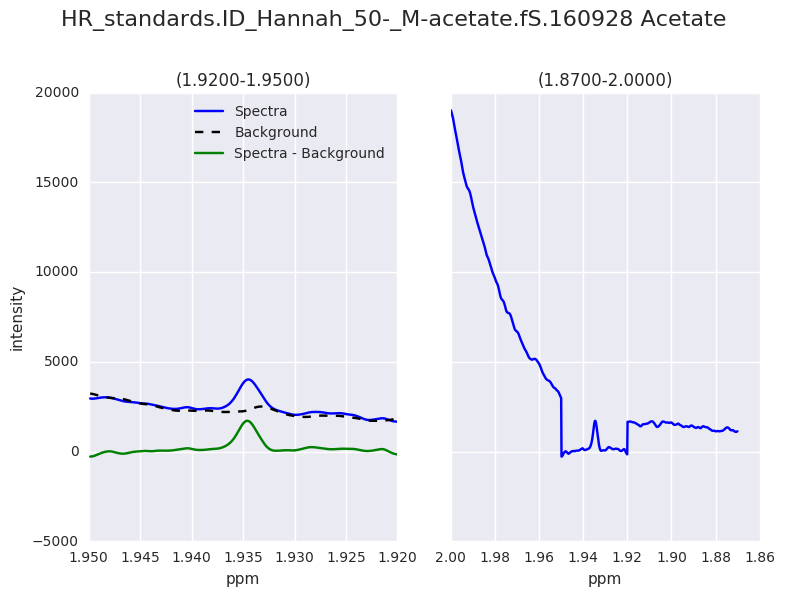

Running inference -- iteration 0


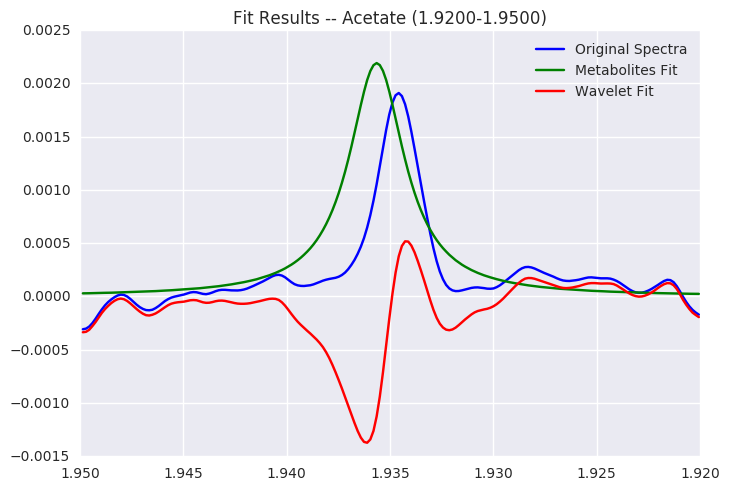

Running inference -- iteration 1


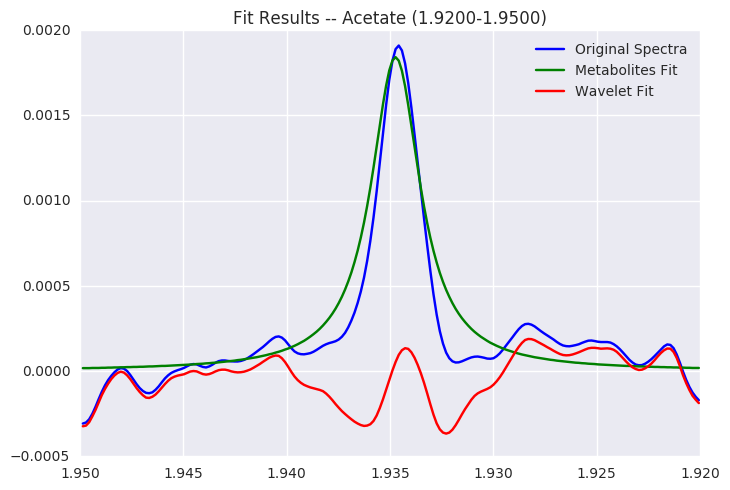

Running inference -- iteration 2


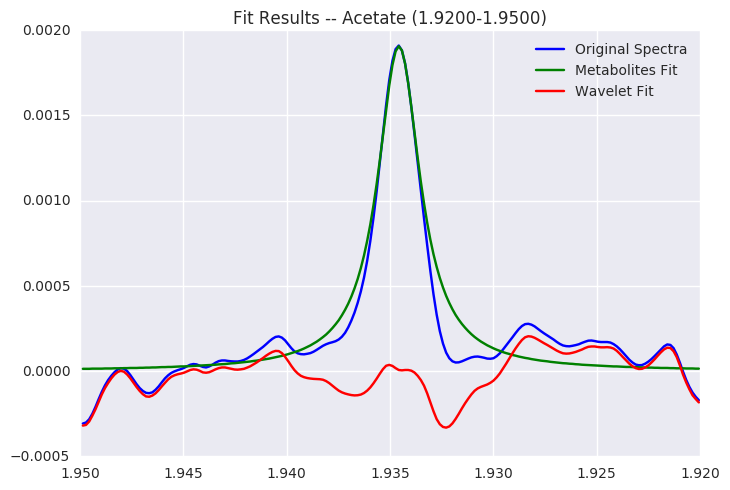

In [9]:
process_spiked(input_dirs, 'Acetate', 4000, 1000, 3)

### 2.2. Try fitting alanine

The fit results for alanine look pretty good .. ?

Metabolite Alanine
Now processing /home/rstudio/NMR/Hannah_NMR/HR_standards.ID_Hannah_50-_M-alanine.fS.160928
Doing background correction


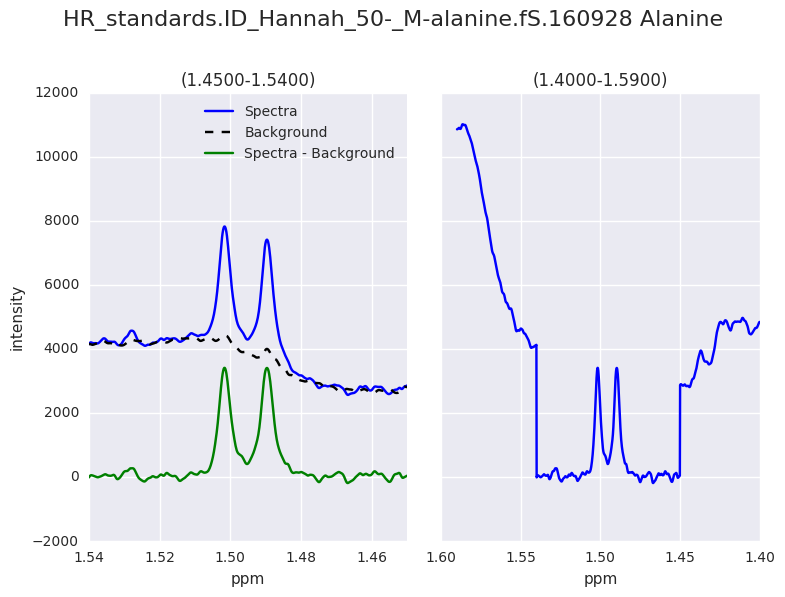

Running inference -- iteration 0


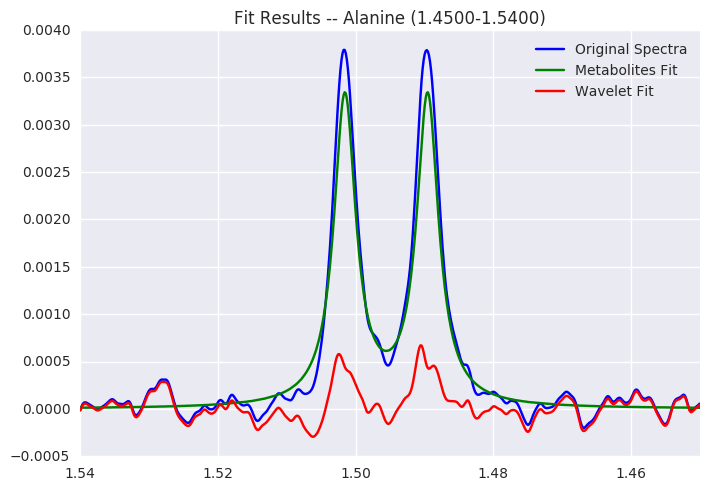

Running inference -- iteration 1


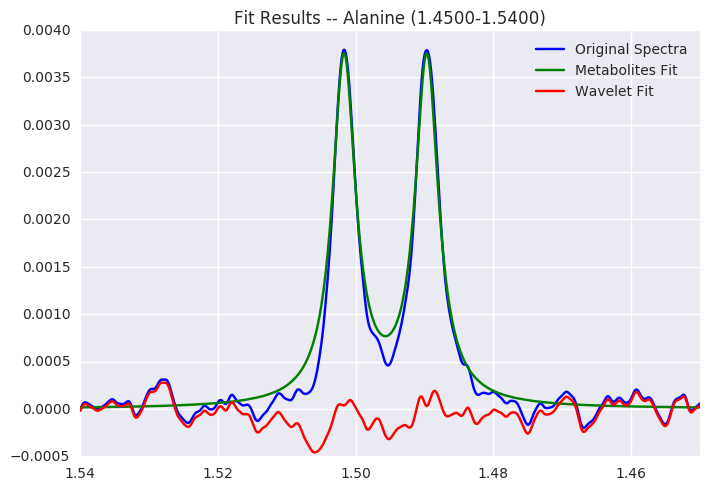

Running inference -- iteration 2


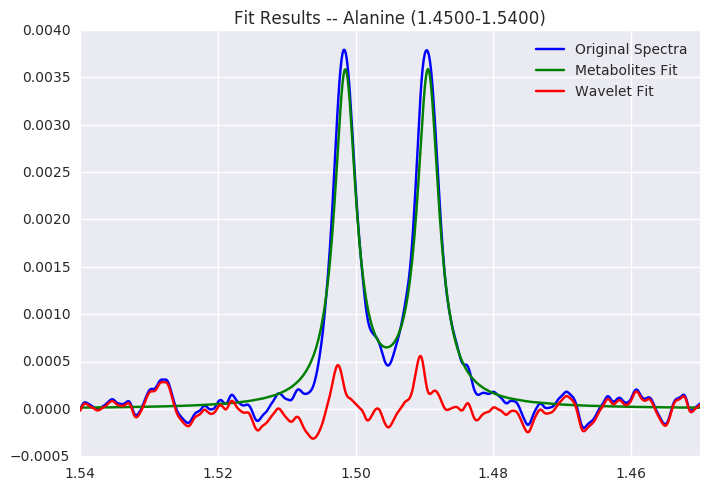

In [11]:
process_spiked(input_dirs, 'Alanine', 4000, 1000, 3)

### 2.3. Try fitting citrate

I wonder why the the doublet multiplets for citrate in the data do not seem to be of the same height?

Second and third results (iteration 1, 2) are also pretty bad. We need to to further penalise the wavelets from going below 0. Tim mentioned this could be a tricky thing ..?

Now processing /home/rstudio/NMR/Hannah_NMR/HR_standards.ID_Hannah_50-_M-citrate.fS.160928
Doing background correction


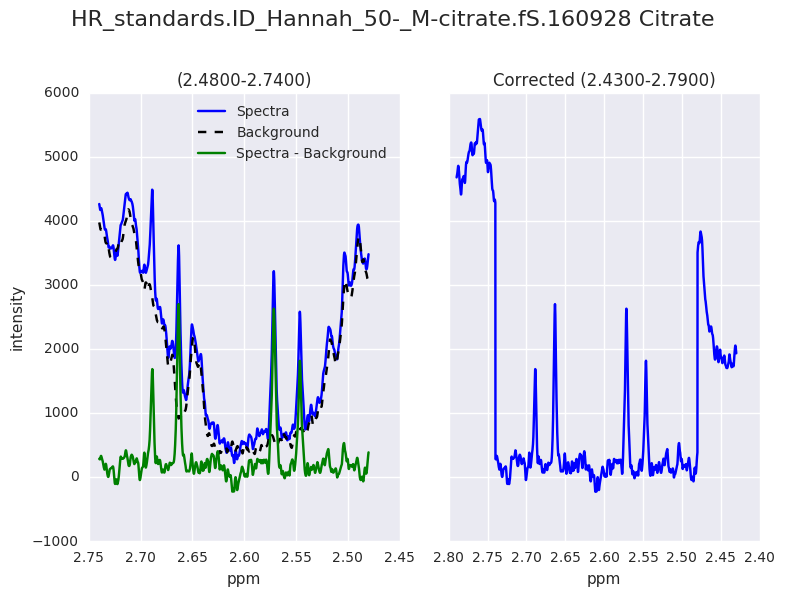

Running inference -- iteration 0


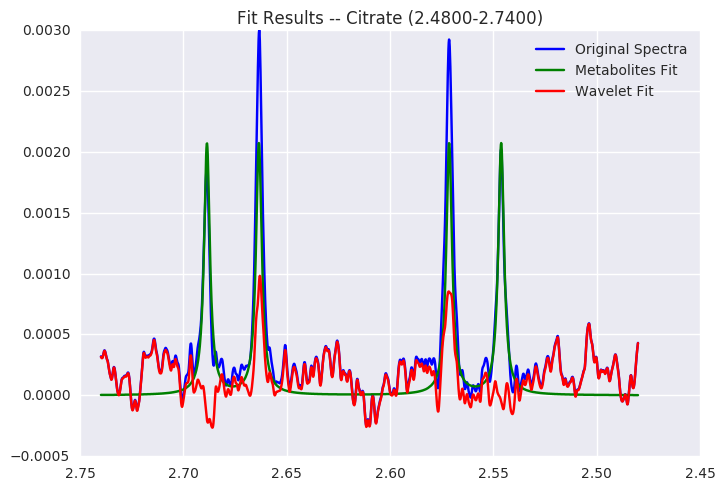

Running inference -- iteration 1


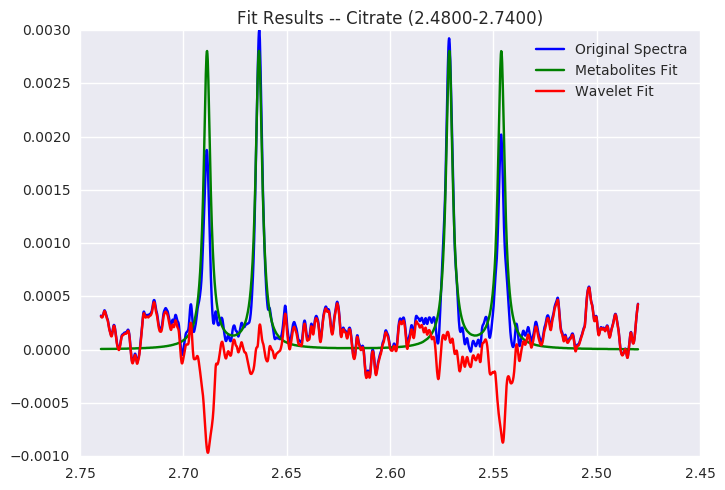

Running inference -- iteration 2


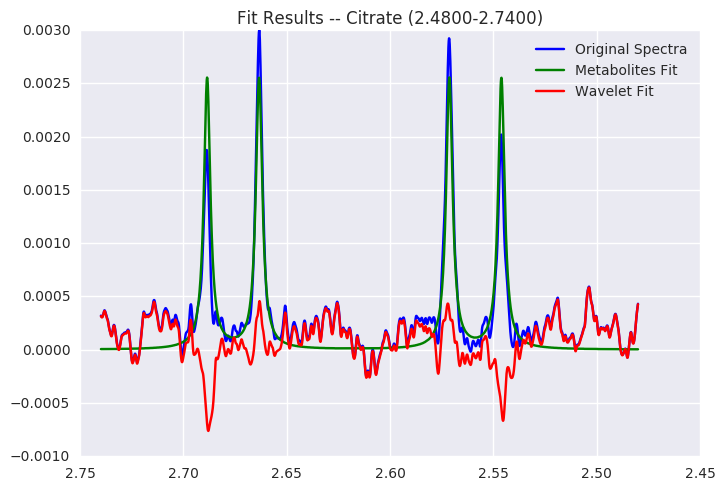

In [10]:
process_spiked(input_dirs, 'Citrate', 4000, 1000, 3)

### 2.4. Try fitting the glutamine triplet at 3.8 ppm

The signal intensity is very low ..? Not sure if the fit can be considered good or not.

Now processing /home/rstudio/NMR/Hannah_NMR/HR_standards.ID_Hannah_50-_M-glutamine.fS.160928
Doing background correction


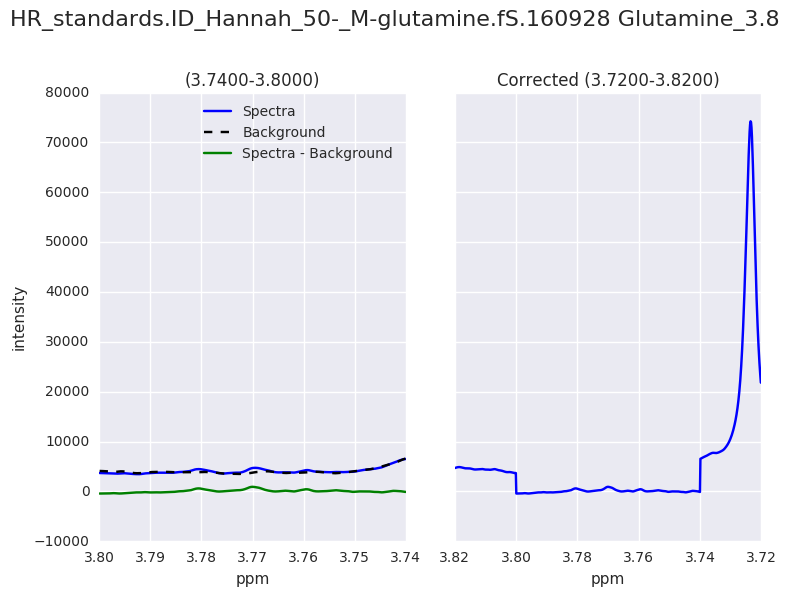

Running inference -- iteration 0


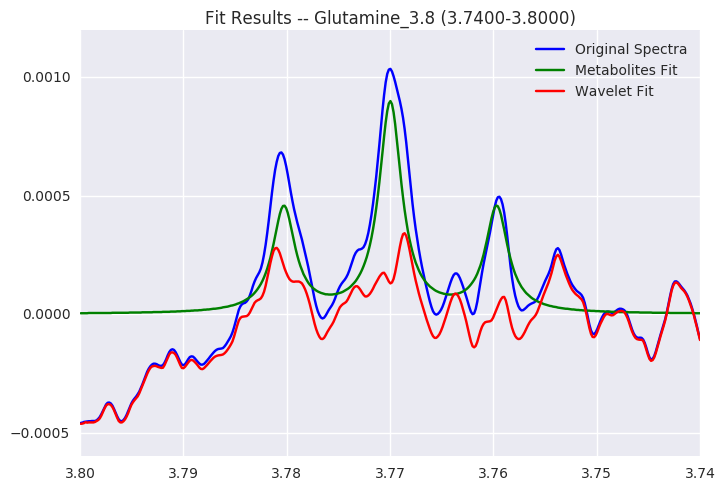

Running inference -- iteration 1


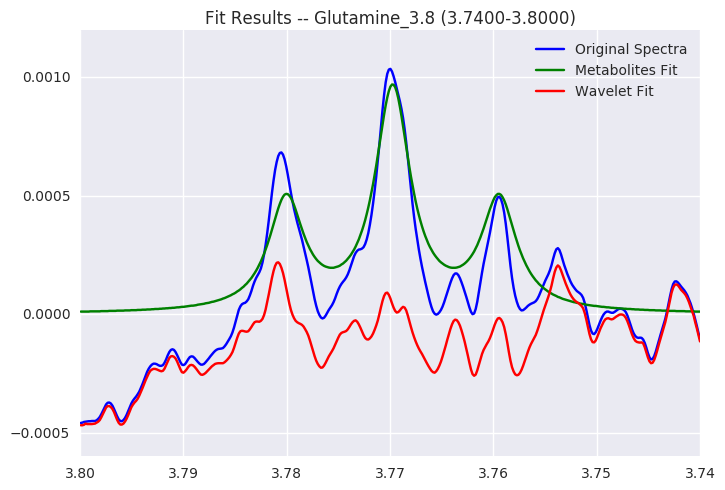

Running inference -- iteration 2


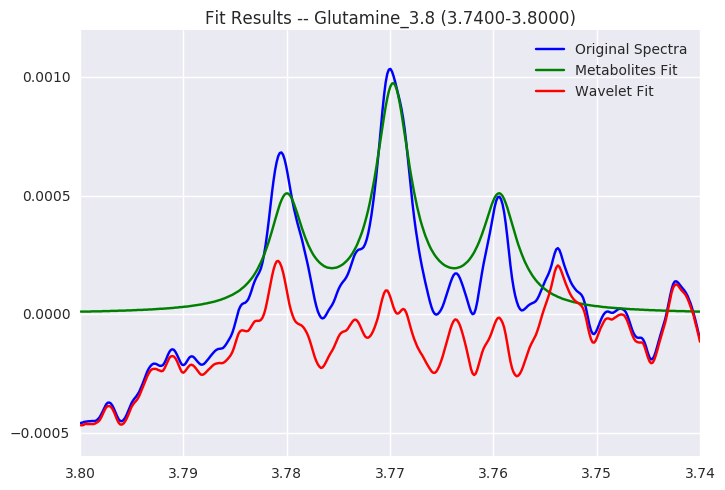

In [16]:
process_spiked(input_dirs, 'Glutamine_3.8', 4000, 1000, 3)

Unfinished code .. please ignore

In [ ]:
# need to parse the output correctly when >1 spectra being run at once through batman ..

# from rpy2.robjects import pandas2ri
# pandas2ri.activate() # to convert between R <-> pandas dataframes

# bm_out = results[0]

# output_dir = bm_out[bm_out.names.index('outputDir')][0]
# beta = bm_out[bm_out.names.index('beta')]
# beta_sam = bm_out[bm_out.names.index('betaSam')]
# specfit = bm_out[bm_out.names.index('sFit')]

# print output_dir
# print beta
# print beta_sam
# print [column.rclass[0] for column in beta_sam]

# n_col = len(beta_sam)
# for i in range(n_col):
#     col = beta_sam.rx(i)
#     print col
#     break
    
# print beta_sam.colnames
# print beta_sam.rownames
    
# i = 1
# column = beta_sam[i]
# print dir(column)
# print beta_sam.rx(i)
# print column
# print column.names

# print specfit

# beta_df = pandas2ri.ri2py(beta)
# beta_sam_df = pandas2ri.ri2py(beta_sam)

# self.beta_df = pandas2ri.ri2py(beta)
# self.beta_sam_df = pandas2ri.ri2py(beta_sam).transpose()

## 3. Test with native serum data

First attempt of trying to fit multiple (8) metabolites on a native serum data. It looks okay to me ..? I left it to run overnight with 100k MCMC samples.

In [8]:
spectra_dirs = [
    '/home/rstudio/NMR/Maria_25_07_2016/data/bruker/normal_serum/Maria_serum_b_1',
]
background_dirs = [
    '/home/rstudio/NMR/Maria_25_07_2016/data/bruker/unspiked_dialised/Maria_unspiked_dialysed1',
    '/home/rstudio/NMR/Maria_25_07_2016/data/bruker/unspiked_dialised/Maria_unspiked_dialysed2',
    '/home/rstudio/NMR/Maria_25_07_2016/data/bruker/unspiked_dialised/Maria_unspiked_dialysed3',    
]
pattern = 'cpmg'
working_dir = 'test/temp'

In [9]:
def process_native(spectra_dirs, background_dirs, metabolites, 
                   n_burnin, n_sample, n_iter, verbose=False):   

    spectra = spectra_dirs[0]
    
    print 'Now processing', spectra
    bm = PyBatman([spectra], background_dirs, pattern, working_dir, db, verbose=verbose)

    default = bm.get_default_params(metabolites)
    default = default.set('nItBurnin', n_burnin).set('nItPostBurnin', n_sample).set('downSamp', 3)        

    bm.background_correct(default)
    # bm.baseline_correct(default)        

    results = pipeline(bm, n_iter, metabolites, default, verbose)
    print

In [10]:
metabolites = ['Acetate', 'Alanine', 'Citrate', 'Creatinine', 
               'Glutamine_3.8', 'Pyruvate_2.4', 'TMAO', 'Lactate']

Now processing /home/rstudio/NMR/Maria_25_07_2016/data/bruker/normal_serum/Maria_serum_b_1
Working directory = test/temp
- batman_input = test/temp/20161118_022610_0w1xVM/runBATMAN/BatmanInput
- batman_output = test/temp/20161118_022610_0w1xVM/runBATMAN/BatmanOutput
Processing /home/rstudio/NMR/Maria_25_07_2016/data/bruker/normal_serum/Maria_serum_b_1/422/pdata/1
Processing /home/rstudio/NMR/Maria_25_07_2016/data/bruker/unspiked_dialised/Maria_unspiked_dialysed1/22/pdata/1
Processing /home/rstudio/NMR/Maria_25_07_2016/data/bruker/unspiked_dialised/Maria_unspiked_dialysed2/32/pdata/1
Processing /home/rstudio/NMR/Maria_25_07_2016/data/bruker/unspiked_dialised/Maria_unspiked_dialysed3/42/pdata/1
Loaded (131072, 2)
Spectra written to test/temp/20161118_022610_0w1xVM/runBATMAN/BatmanInput/NMRdata_temp.txt
Doing background correction


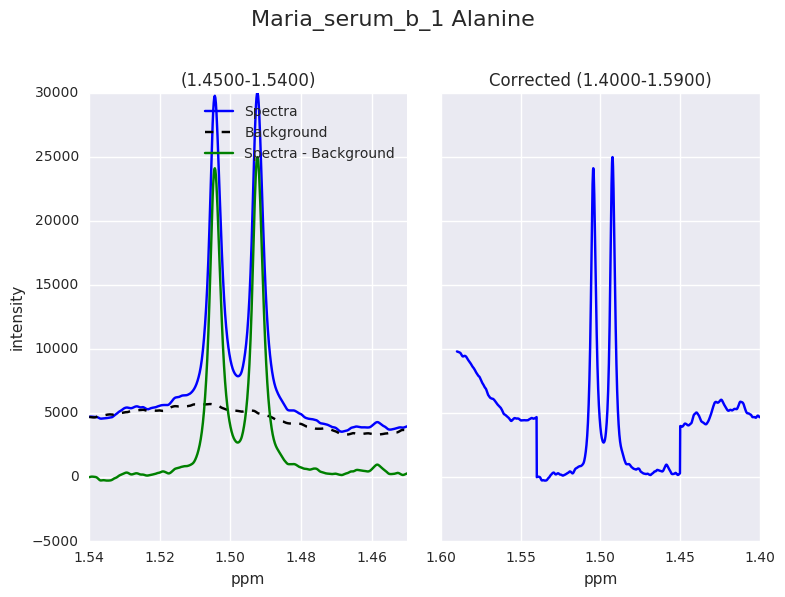

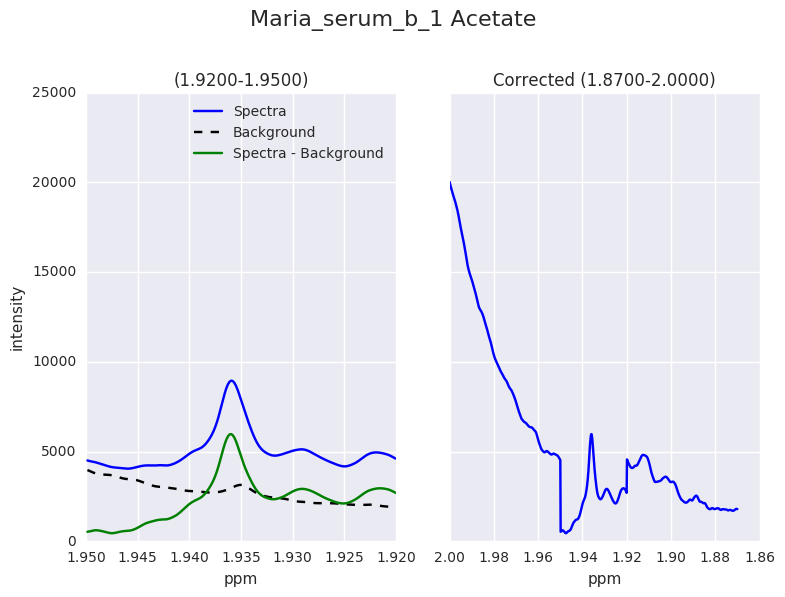

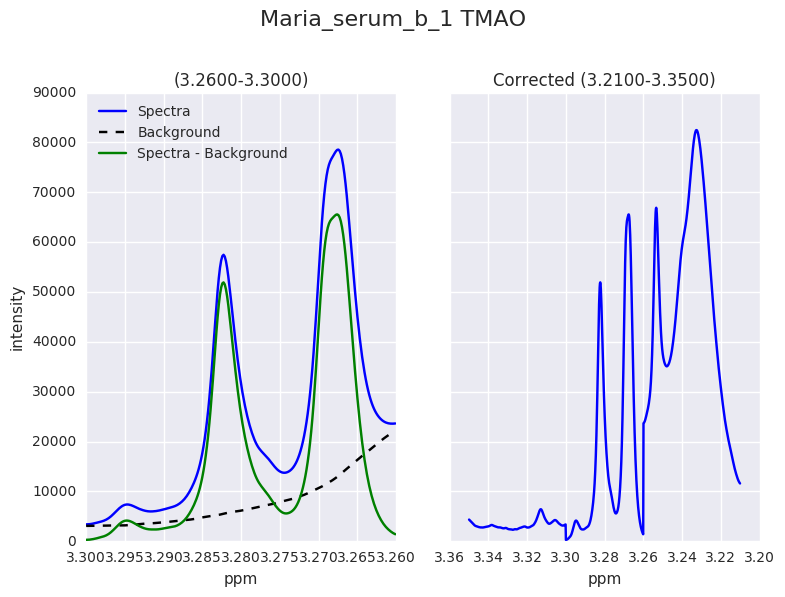

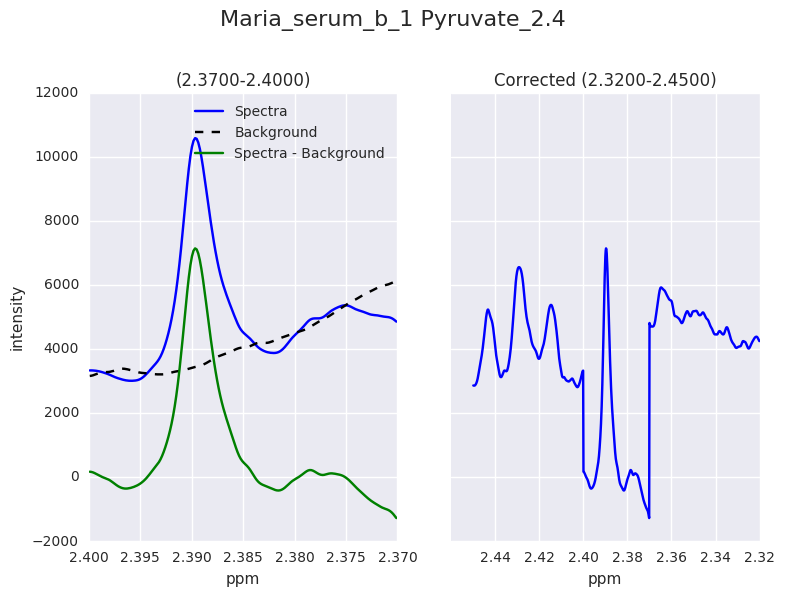

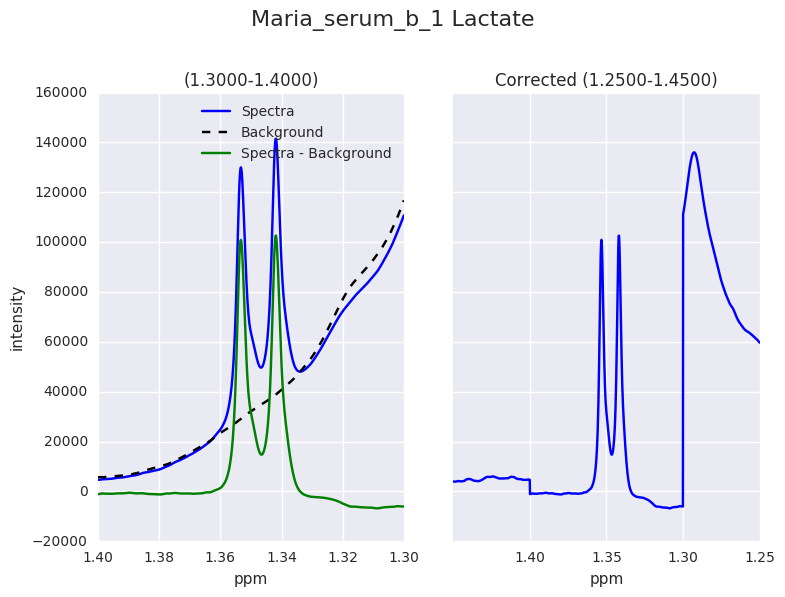

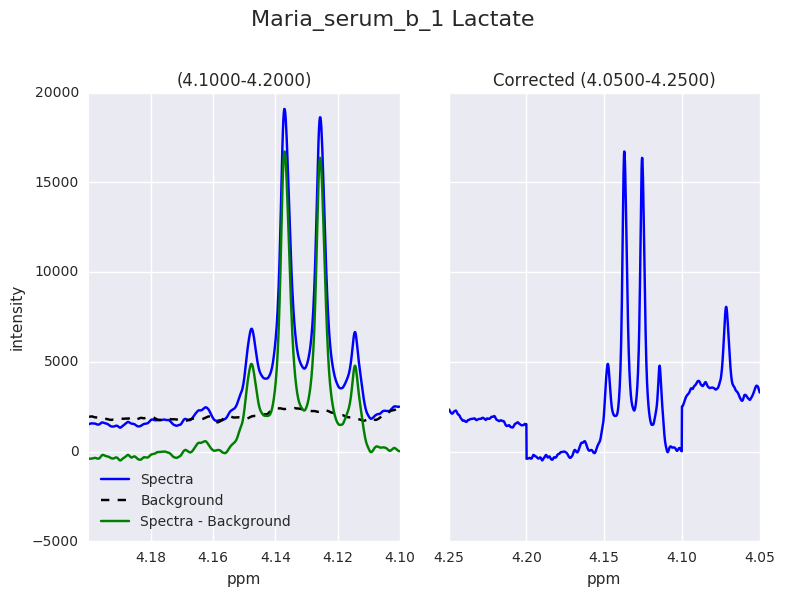

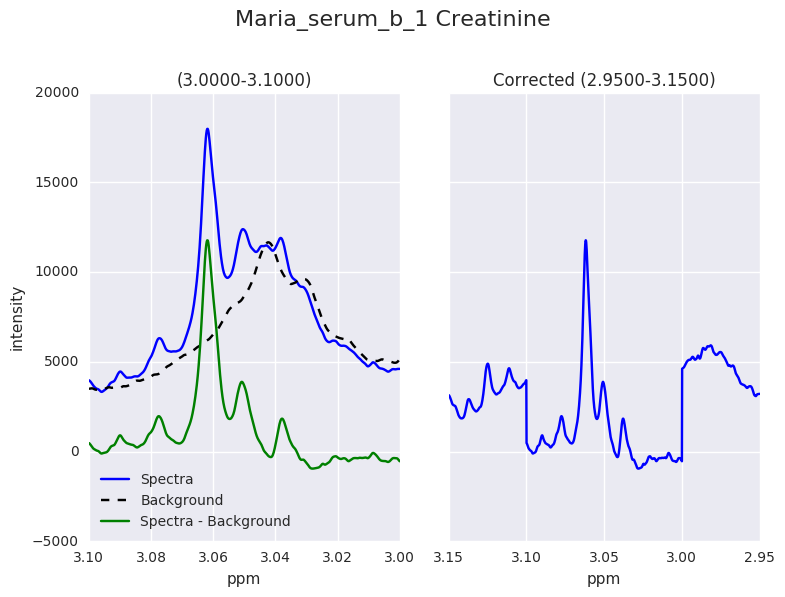

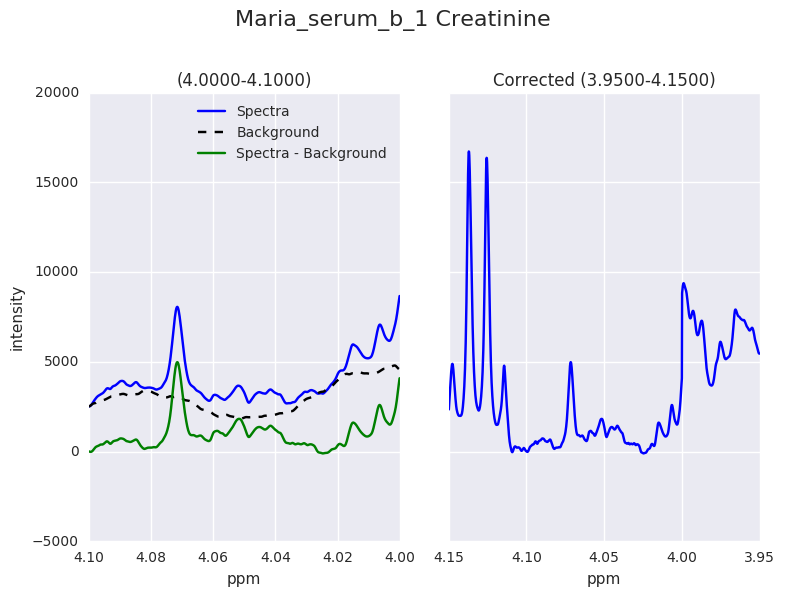

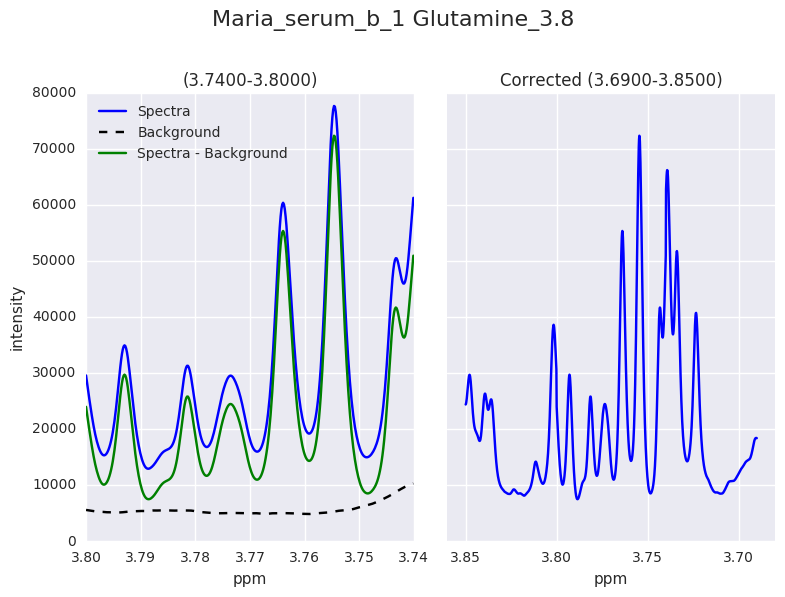

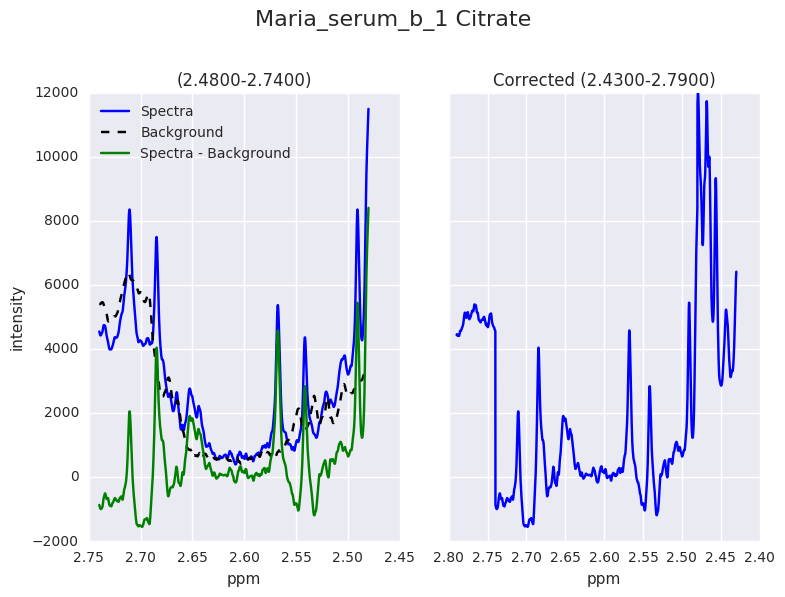

Spectra written to test/temp/20161118_022610_0w1xVM/runBATMAN/BatmanInput/NMRdata_temp.txt
Running inference -- iteration 0
metabolites list = test/temp/20161118_022610_0w1xVM/runBATMAN/BatmanInput/metabolitesList.csv
multiplet data = test/temp/20161118_022610_0w1xVM/runBATMAN/BatmanInput/multi_data_user.csv
chem shift = test/temp/20161118_022610_0w1xVM/runBATMAN/BatmanInput/chemShiftPerSpec.csv
batman options = test/temp/20161118_022610_0w1xVM/runBATMAN/BatmanInput/batmanOptions.txt


,Metabolite
0,Alanine
1,Acetate
2,TMAO
3,Pyruvate_2.4
4,Lactate
5,Creatinine
6,Glutamine_3.8
7,Citrate


,Metabolite,pos_in_ppm,couple_code,J_constant,relative_intensity,overwrite_pos,overwrite_truncation,Include_multiplet
0,Alanine,1.495,1,7.21,3,n,n,1
1,Acetate,1.934,0,0,3,n,n,1
2,TMAO,3.278,0,0,9,n,n,1
3,Pyruvate_2.4,2.390,0,0,3,n,n,1
4,Lactate,1.343,1,6.8,3,n,n,1
5,Lactate,4.126,3,6.7,1,n,n,1
6,Creatinine,3.058,0,0,3,n,n,1
7,Creatinine,4.068,0,0,2,n,n,1
8,Glutamine_3.8,3.770,2,6.18,1,n,n,1
9,Citrate,2.675,1,15.08,2,n,n,1


,multiplets,pos_in_ppm,Maria_serum_b_1
0,Alanine,1.495,n
1,Acetate,1.934,n
2,TMAO,3.278,n
3,Pyruvate_2.4,2.390,n
4,Lactate,1.343,n
5,Lactate,4.126,n
6,Creatinine,3.058,n
7,Creatinine,4.068,n
8,Glutamine_3.8,3.770,n
9,Citrate,2.675,n



----------------------------------------------------------------
Parameters
----------------------------------------------------------------
ppmRange - ppm ranges for analysis. Please put each ppm range in a pair of parentheses in the same line separate start and end ppm values with a comma, and separate each set of ppm range with space, e.g. (-0.05,0.05) (1.44,1.52): (1.45, 1.54) (1.92, 1.95) (3.26, 3.3) (2.37, 2.4) (1.3, 1.4) (4.1, 4.2) (3.0, 3.1) (4.0, 4.1) (3.74, 3.8) (2.48, 2.74)
specNo - Ranges of spectra number to be included (e.g. 1,3-4 etc.): 1-1
paraProc - No of parallel processes (multicores) (only 1 core will be used for single spectrum): 4
negThresh - Truncation threshold for negative intensities: -0.5
scaleFac - Intensity scale factor: 900000
downSamp - Down sampling factor: 3
hiresFlag - Save metabolite fit at resolution of original spectrum? (Yes - 1 / No - 0): 1
randSeed - Random number seed: 516765
nItBurnin - Number of burn-in iterations: 99000
nItPostBurnin - Numbe

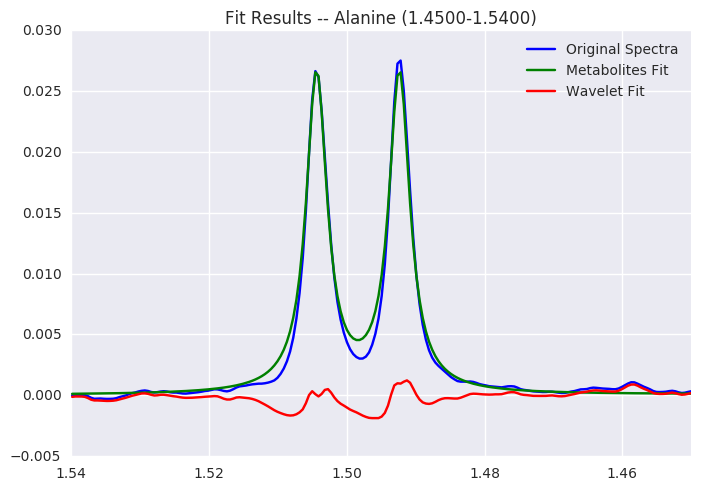

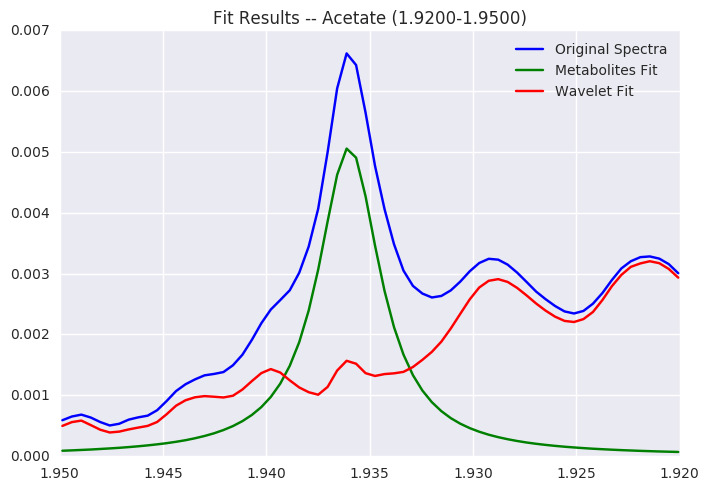

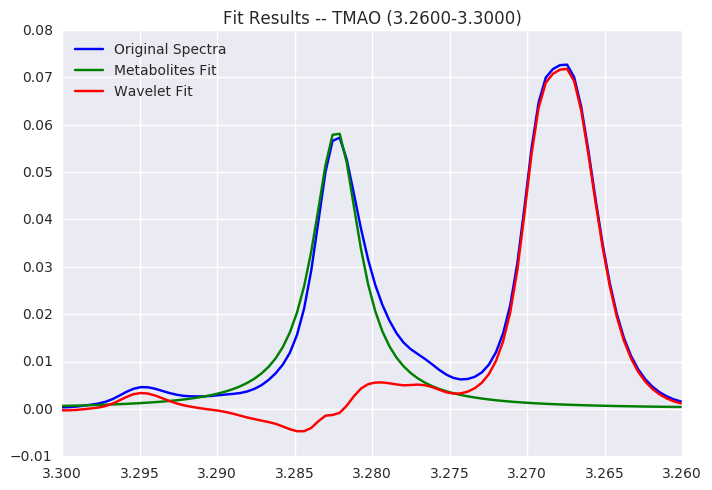

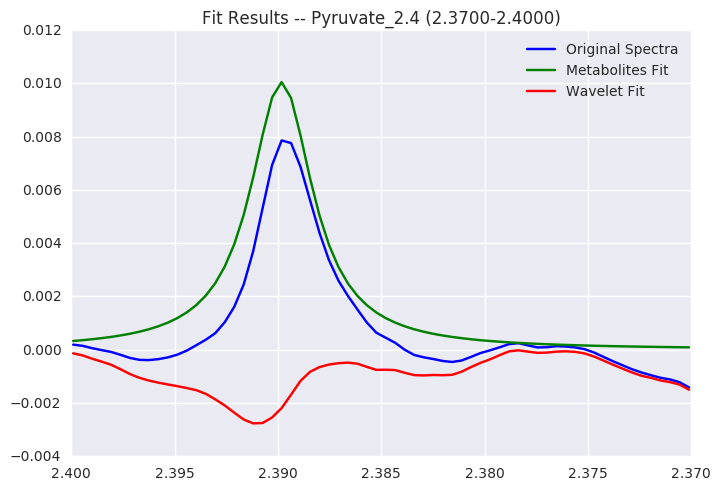

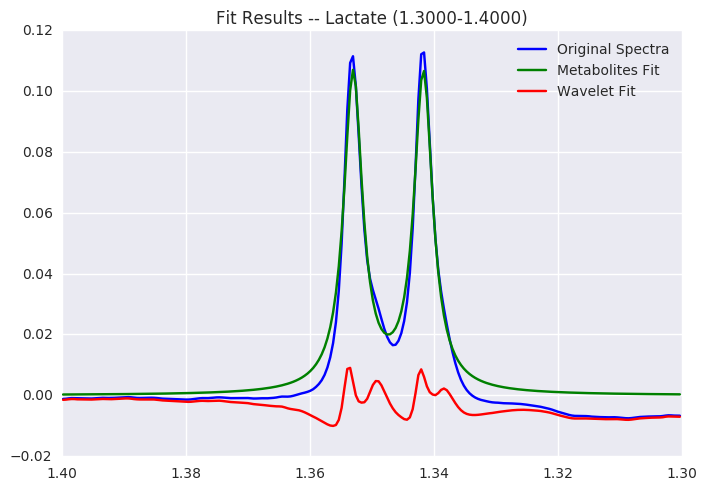

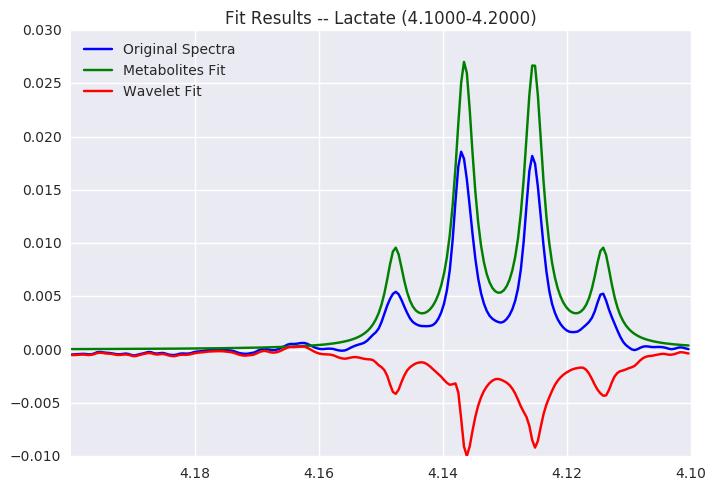

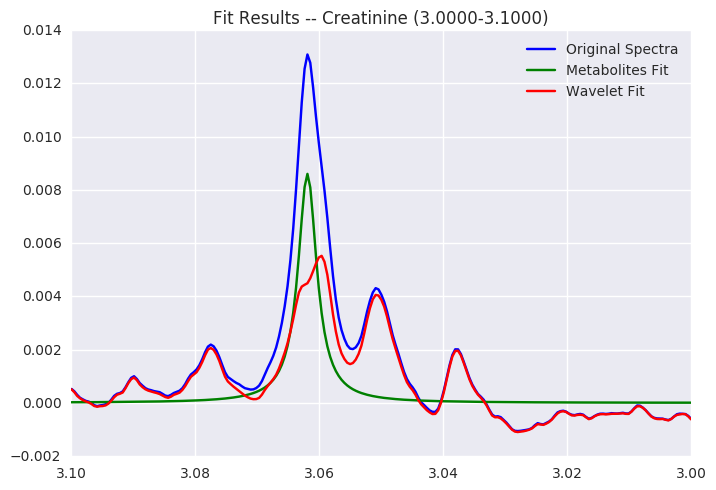

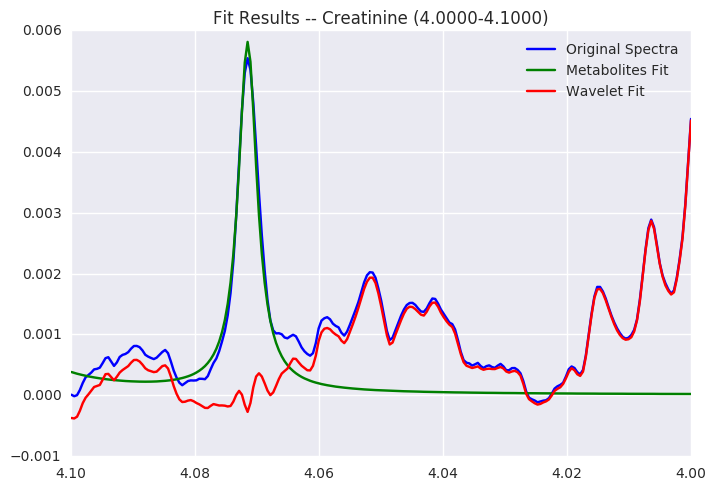

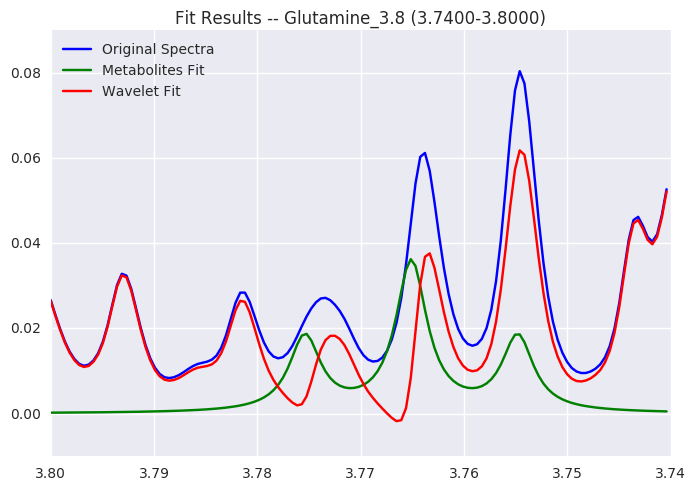

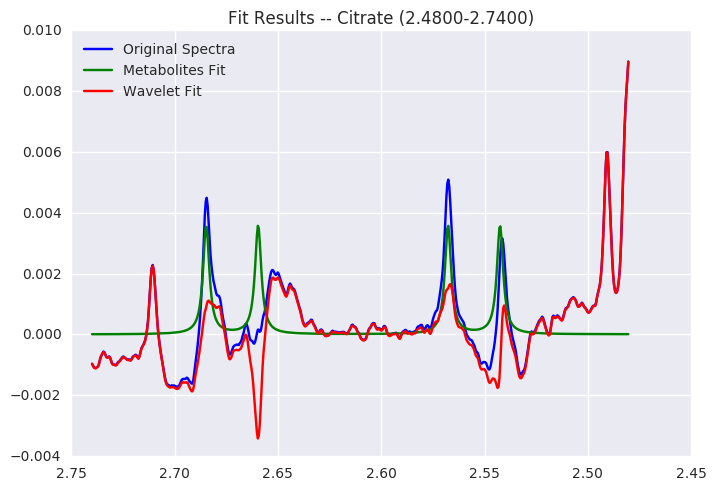

In [11]:
process_native(spectra_dirs, background_dirs, metabolites, 99000, 1000, 1, verbose=True)